# Lab06 Решение

## Задача

По имеющимся данным о рейтингах фильмов (MovieLens: 100 000 рейтингов) посчитать агрегированную статистику по ним.

In [1]:
#Lab06 personal data
my_id = 405

In [2]:
#Lab06s personal data
k = 20
z = 1.645

In [3]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.2.0 pyspark-shell --num-executors 5'
os.environ["PYSPARK_PYTHON"]='python3'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.6-src.zip'))
#os.environ["PYSPARK_PYTHON"] = 'python3'
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.0
      /_/

Using Python version 3.6.4 (default, Jan 28 2018 00:00:00)
SparkSession available as 'spark'.


In [4]:
sc

<SparkContext master=yarn appName=pyspark-shell>

## Loading user data

In [5]:
# Loading from HDFS, make sure you put you data into hdfs first
user_data_src = sc.textFile("/share/ml-100k/u.data")

In [6]:
# Data lookup:
user_data_src.first()

'196\t242\t3\t881250949'

In [7]:
user_data = user_data_src.map(lambda u: u.split("\t"))

In [8]:
user_data.take(5)

[['196', '242', '3', '881250949'],
 ['186', '302', '3', '891717742'],
 ['22', '377', '1', '878887116'],
 ['244', '51', '2', '880606923'],
 ['166', '346', '1', '886397596']]

In [9]:
num_users = user_data.count()
num_users

100000

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
user_ages = user_data.map(lambda u: int(u[1]))
user_ages.take(5)

[242, 302, 377, 51, 346]

(array([23671., 28410., 14237., 11567.,  9108.,  5549.,  4332.,  1893.,
          851.,   382.]),
 array([1.0000e+00, 1.6910e+02, 3.3720e+02, 5.0530e+02, 6.7340e+02,
        8.4150e+02, 1.0096e+03, 1.1777e+03, 1.3458e+03, 1.5139e+03,
        1.6820e+03]),
 <a list of 10 Patch objects>)

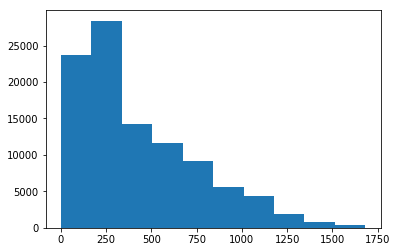

In [12]:
ages = user_ages.collect()
hist(ages, bins=10)

In [13]:
ages = user_ages.collect

## Loading movie data

In [14]:
movie_data_src = sc.textFile("/share/ml-100k/u.item")
movie_data_src.first()

'1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0'

In [15]:
movie_data_src.take(10)

['1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0',
 '2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0',
 '3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0',
 '4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0',
 '5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0',
 '6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0',
 '7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0',
 '8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title

In [16]:
movie_data = movie_data_src.map(lambda line: line.split("|"))
movie_data.take(5)

[['1',
  'Toy Story (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)',
  '0',
  '0',
  '0',
  '1',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['2',
  'GoldenEye (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?GoldenEye%20(1995)',
  '0',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0'],
 ['3',
  'Four Rooms (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0'],
 ['4',
  'Get Shorty (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)',
  '0',
  '1',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['5',
  'Copycat 

In [17]:
from datetime import datetime

def get_year(date_string):
    try:
        return int(datetime.strptime(date_string, "%d-%b-%Y").year)
    except:
        return 1899

In [18]:
movie_years = movie_data.map(lambda m: get_year(m[2]))

In [19]:
movie_years.take(10)

[1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1996]

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,
          1.,   2.,   4.,   4.,   2.,   4.,   3.,   7.,   8.,   5.,   2.,
          4.,   5.,   4.,   5.,   5.,   3.,   4.,   7.,   5.,   3.,   2.,
          7.,   5.,   4.,   8.,   9.,   4.,   5.,   3.,   5.,   6.,   2.,
          5.,   2.,   5.,   6.,   4.,   3.,   7.,   3.,   4.,   8.,   6.,
          5.,   4.,   4.,   9.,   8.,  12.,  13.,   5.,   8.,   7.,  15.,
         13.,  11.,  15.,  24.,  22.,  37., 126., 214., 219., 355., 286.,
         65.]),
 array([1899.  , 1899.99, 1900.98, 1901.97, 1902.96, 1903.95, 1904.94,
        1905.93, 1906.92, 1907.91, 1908.9 , 1909.89, 1910.88, 1911.87,
        1912.86, 1913.85, 1914.84, 1915.83, 1916.82, 1917.81, 1918.8 ,
        1919.79, 1920.78, 1921.77, 1922.76, 1923.75, 1924.74, 1925.73,
        1926.72, 1927.71, 1928.7 ,

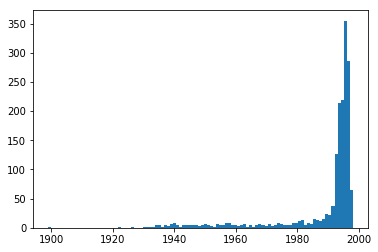

In [20]:
years = movie_years.collect()
hist(years,bins=100)

## Loading ratings data

In [21]:
# user id | item id | rating | timestamp
ratings_src = sc.textFile("/share/ml-100k/u.data")
ratings_src.first()

'196\t242\t3\t881250949'

In [22]:
ratings_data = ratings_src.map(lambda r: r.split("\t"))
ratings_data.take(3)

[['196', '242', '3', '881250949'],
 ['186', '302', '3', '891717742'],
 ['22', '377', '1', '878887116']]

In [23]:
ratings = ratings_data.map(lambda r: int(r[2])).collect()

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

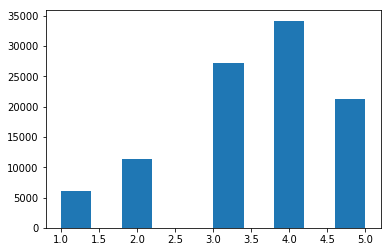

In [24]:
hist(ratings)

(array([ 6110., 11370., 27145., 34174., 21201.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

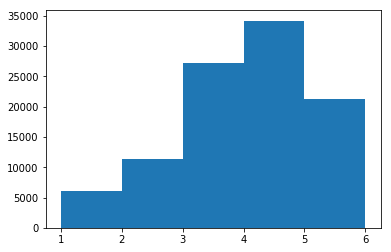

In [25]:
hist(ratings,bins=[1,2,3,4,5,6])

In [26]:
# 0: user id | 1: item id | 2: rating | 3: timestamp
ratings_map = ratings_data.map(lambda r: (r[1], int(r[2])))

In [27]:
#item_id, rating
ratings_map.first()

('242', 3)

#### 1. Количество человек n, поставивших рейтинг фильму

In [28]:
#kv = {item_id: 1}
n1_kv_m = ratings_data.map( lambda x: (x[1], 1) )

#kv = {item_id: sum}
n1 = n1_kv_m.reduceByKey( lambda pv,v: pv+v )

n1.take(5)

[('346', 126), ('474', 194), ('265', 227), ('465', 85), ('451', 170)]

#### 2. Средний рейтинг фильма (сумма рейтингов фильма/количество человек, оценивних фильм)

In [29]:
#kv = {item_id: (rating, 1)}
n2_kv_m = ratings_data.map( lambda x: (x[1], (int(x[2]), 1)) )

#kv = {item_id: (rating_sum, count)}
n2_kv_r = n2_kv_m.reduceByKey( lambda pv,v: (pv[0]+v[0], pv[1]+v[1]) )
n2_kv_r.first()

('346', (459, 126))

In [30]:
from __future__ import division
n2 = n2_kv_r.map( lambda x: (x[0], x[1][0] / x[1][1]) )

n2.take(5)

[('346', 3.642857142857143),
 ('474', 4.252577319587629),
 ('265', 3.8634361233480177),
 ('465', 3.5647058823529414),
 ('451', 3.347058823529412)]

#### 3. Количество человек m, оценивших фильм положительно. Оценки 4 и выше -- считаются положительными.

In [31]:
#kv = {item_id: (1 if rating >=4 else 0)}
n3_kv_m = ratings_data.map( lambda x: (x[1], 1 if int(x[2]) >=4 else 0) )
n3_kv_m.take(5)

[('242', 0), ('302', 0), ('377', 0), ('51', 0), ('346', 0)]

In [32]:
#kv = {item_id: sum}
n3 = n3_kv_m.reduceByKey( lambda pv,v: pv+v )

In [33]:
n3.take(5)

[('346', 77), ('474', 154), ('265', 151), ('465', 47), ('451', 87)]

#### 4. Доля людей, оценивших фильм положительно (пункт 3/пункт 1 или m/n).¶

In [34]:
#kv = {item_id: (n1, n3) }
n4_kv_m = n1.join(n3)
n4 = n4_kv_m.map( lambda x: (x[0], x[1][1] / x[1][0]) )
n4.take(5)

[('346', 0.6111111111111112),
 ('474', 0.7938144329896907),
 ('265', 0.6651982378854625),
 ('465', 0.5529411764705883),
 ('451', 0.5117647058823529)]

#### 5. Глобальное среднее по всему датасету. Сумма всех оценок по всем фильмам/Количество всех оценок по всем фильмам

In [35]:
#kv = {rating}
n5_kv_m = ratings_data.map( lambda x: x[2] )

n5 = n5_kv_m.reduce( lambda pv,v: int(pv)+int(v) ) / n5_kv_m.count()
n5

3.52986

#### 6. Оценку, поправленную на нехватку данных:

In [36]:

#n2_kv_r = {item_id: (rating_sum, count)}
#n2_kv_r.take(5)
n6 = n2_kv_r.map( lambda x: (x[0], (x[1][0] + k * n5) / (x[1][1] + k) ) )

In [37]:
n6.take(5)

[('346', 3.627378082191781),
 ('474', 4.185033644859813),
 ('265', 3.8364259109311742),
 ('465', 3.558068571428571),
 ('451', 3.366301052631579)]

#### 7. Нижнюю и верхнюю границы доверительного интервала оценки (Wilson score interval) из лекции с заданным уровнем доверия.

In [38]:
#kv = {item_id: (n1, n4) }
n7_kv_m = n1.join(n4)
n7 = n7_kv_m.map( lambda x: ( x[0], (1 / (1 + z**2/x[1][0])) * (x[1][1] + z**2/(2*x[1][0]) - z*(x[1][1]*(1-x[1][1])/x[1][0] + z**2/(4*x[1][0]**2))**0.5 ) ) )



In [39]:
n7.take(5)

[('346', 0.5380494622689577),
 ('465', 0.46396057344432734),
 ('451', 0.4490107120860312),
 ('86', 0.6912853653852403),
 ('257', 0.5871350214927582)]

#### Рекомендовать топ 10 фильмов (если рейтинги совпадают, то сортировать по алфавиту названий фильмов от A до Z):

#### 1. По откликам (пункт 1) - поле “top10_rates”

In [40]:
#kv = {item_id: (name, n1) }

movie_data_n1 = movie_data.join(n1)
top10_rates = [tp[0] for tp in movie_data_n1.top(10, lambda x: x[1][1])]
movie_data_n1.top(10, lambda x: x[1][1])

[('50', ('Star Wars (1977)', 583)),
 ('258', ('Contact (1997)', 509)),
 ('100', ('Fargo (1996)', 508)),
 ('181', ('Return of the Jedi (1983)', 507)),
 ('294', ('Liar Liar (1997)', 485)),
 ('286', ('English Patient, The (1996)', 481)),
 ('288', ('Scream (1996)', 478)),
 ('1', ('Toy Story (1995)', 452)),
 ('300', ('Air Force One (1997)', 431)),
 ('121', ('Independence Day (ID4) (1996)', 429))]

#### 2. По среднему рейтингу (пункт 2) - поле “top10_average”

In [41]:
top10_average = movie_data.join(n2).sortBy(lambda x: (-x[1][1], x[1][0])).keys().take(10)
movie_data.join(n2).sortBy(lambda x: (-x[1][1], x[1][0])).take(10)

[('1536', ('Aiqing wansui (1994)', 5.0)),
 ('1653', ('Entertaining Angels: The Dorothy Day Story (1996)', 5.0)),
 ('814', ('Great Day in Harlem, A (1994)', 5.0)),
 ('1201', ('Marlene Dietrich: Shadow and Light (1996) ', 5.0)),
 ('1189', ('Prefontaine (1997)', 5.0)),
 ('1467', ('Saint of Fort Washington, The (1993)', 5.0)),
 ('1500', ('Santa with Muscles (1996)', 5.0)),
 ('1599', ("Someone Else's America (1995)", 5.0)),
 ('1293', ('Star Kid (1997)', 5.0)),
 ('1122', ('They Made Me a Criminal (1939)', 5.0))]

#### 3. По среднему рейтингу с регуляризацией k (пункт 6) - поле “top10_rating”

In [42]:
top10_rating = movie_data.join(n6).sortBy(lambda x: (-x[1][1], x[1][0])).keys().take(10)
movie_data.join(n6).sortBy(lambda x: (-x[1][1], x[1][0])).take(10)

[('318', ("Schindler's List (1993)", 4.407538364779874)),
 ('483', ('Casablanca (1942)', 4.38630114068441)),
 ('64', ('Shawshank Redemption, The (1994)', 4.384809240924092)),
 ('408', ('Close Shave, A (1995)', 4.345433333333333)),
 ('50', ('Star Wars (1977)', 4.331006965174129)),
 ('169', ('Wrong Trousers, The (1993)', 4.330414492753624)),
 ('12', ('Usual Suspects, The (1995)', 4.326122648083623)),
 ('603', ('Rear Window (1954)', 4.312651528384279)),
 ('98', ('Silence of the Lambs, The (1991)', 4.252676097560975)),
 ('127', ('Godfather, The (1972)', 4.2484923787528865))]

#### 4. По нижней границе доверительного интервала Wilson (пункт 7) - поле “top10_lower”

In [43]:
top10_lower = movie_data.join(n7).sortBy(lambda x: (-x[1][1], x[1][0])).keys().take(10)
movie_data.join(n7).sortBy(lambda x: (-x[1][1], x[1][0])).take(10)

[('64', ('Shawshank Redemption, The (1994)', 0.867956044789042)),
 ('479', ('Vertigo (1958)', 0.862713715481725)),
 ('318', ("Schindler's List (1993)", 0.8557848209506228)),
 ('98', ('Silence of the Lambs, The (1991)', 0.8525147988277894)),
 ('483', ('Casablanca (1942)', 0.851348274797206)),
 ('603', ('Rear Window (1954)', 0.8438646356919928)),
 ('427', ('To Kill a Mockingbird (1962)', 0.8405877385000851)),
 ('114',
  ('Wallace & Gromit: The Best of Aardman Animation (1996)',
   0.8360415199849037)),
 ('408', ('Close Shave, A (1995)', 0.835188010484491)),
 ('50', ('Star Wars (1977)', 0.8339986579519124))]

#### Для выданного id фильма:

#### 1. Построить распределения оценок. Получится таблица, где в первом столбце стоят значения оценки (1, 2, 3, 4, 5), а во втором количество человек, поставивших соответствующую оценку - поле “hist_film”


In [44]:

hist_film_kv_f = ratings_data.filter(lambda x: (x[1] == str(my_id)))
hist_film_kv_m = hist_film_kv_f.map(lambda x: (x[2], 1))
hist_film_kv_r = hist_film_kv_m.reduceByKey(lambda x,y: x+y)
hist_film = [i[1] for i in hist_film_kv_r.sortByKey().collect()]

#### 2. Чтобы понять какие оценки предпочитают ставить пользователи Movielens, постройте аналогичное предыдущему пункту 1 распределение оценок только уже для всего датасета - поле “hist_all”

In [45]:

hist_all_kv_m = ratings_data.map(lambda r: (r[2], 1))
hist_all_kv_r = hist_all_kv_m.reduceByKey(lambda x,y: x+y)
hist_all = [i[1] for i in hist_all_kv_r.sortByKey().collect()]

In [46]:
result_json={
            "top10_rates": top10_rates,
            "top10_average": top10_average,
            "top10_rating": top10_rating,
            "top10_lower": top10_lower,
            "hist_film": hist_film,
            "hist_all": hist_all
            }

In [47]:
import json
with open("lab06.json", "w") as j:
    json.dump(result_json,j)

In [48]:
#superachievka
import json
with open("lab06s.json", "w") as j:
    json.dump(result_json,j)